# Code to Analyze Circadian Rythms

## Step 1: Import Libraries

In [2]:
# importing libraries necessary to study circadian rhythms
import pandas as pd
import numpy as np
# from CircadianDynamics import *

### User Defined Functions: This will become a library later on. 

In [83]:
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import cwt, morlet2, butter, sosfilt, find_peaks


# importing libraries necessary to plot
import matplotlib.pyplot as plt

# Transform scales to frequencies
def f (s, w, fs = 1, max_power_indices = None):
        return (w*fs / (2*s[max_power_indices]*np.pi))

def peak_finder(array, total_peaks):
        peak_ind = find_peaks(array, height=0)
        peak_height = np.argsort(peak_ind[1]['peak_heights'])[::-1]
        peak_ind = peak_ind[0][peak_height]
        if np.all(np.isnan(peak_ind)) == False and np.all(peak_ind != None) and total_peaks < len(peak_ind):
                peaks = peak_ind[:total_peaks].astype(int)
               
        else:
                max_datapoint = np.argsort(np.abs(array), axis = 0)[::-1][:total_peaks]
                peaks = max_datapoint.astype(int)
        return peaks

# Compute the CWT
def cwt_compute(signal, sampling_rate = 60, min_period = 18, max_period = 32, components = 1):

        # Compute the frequencies of interest and adjust by period
        frequencies_of_interest = 1/(np.array([min_period, max_period])*sampling_rate)

        # Compute the scales
        w = sampling_rate*max_period # Width of the wavelet in time domain (max_period)
        scales = w / (2 * frequencies_of_interest * np.pi)
        scales = np.arange(scales.min(), scales.max(), w*0.05)

        # Perform the wavelet transform
        cwtmatr = cwt(signal, morlet2, scales, dtype=np.complex128, w = w)

        # Find the top k powers
        top_power_indices = np.apply_along_axis(peak_finder, 0, np.abs(cwtmatr), total_peaks = components)  

        # Find the top k powers, frequencies, and phases
        # powers = np.abs(cwtmatr[top_power_indices, np.arange(len(signal))])
        freqs = f(scales, w, 1, top_power_indices)
        # phases = np.angle(cwtmatr[top_power_indices, np.arange(len(signal))])

        return freqs

# Cosinor analysis
def multicomponent_cosinor(freqs):
        # Compute the cosinor
        linear_space = np.repeat(np.arange(0,freqs.shape[1]).reshape(-1,1).T, repeats = freqs.shape[0], axis=0)

        cosine_component = np.cos(linear_space * (np.pi*2*freqs))
        sine_component = np.sin(linear_space * (np.pi*2*freqs))

        synthetic_signal = np.vstack((cosine_component, sine_component))
        
        return synthetic_signal

def signal_smoother(signal, sampling_rate = 60, min_period = 18, max_period = 32, order = 2):
        sos = butter(order, [1/max_period, 1/min_period], 'bandpass', fs=sampling_rate, output='sos')
        smooth_signal = sosfilt(sos, signal)
        return smooth_signal
        

# Linar Regression
def cosinor_lm(signal, synthetic_signal):
        # Create the model
        X = sm.add_constant(synthetic_signal.T)
        model = sm.OLS(signal, X, hasconst=True)
        # Fit the model to the data
        results = model.fit()
        # Evaluate the model
        return results

# Rolling Regression
def rolling_cosinor_lm(signal, synthetic_signal, sampling_rate = 60, max_period = 32):
        # Create the model
        # Add a paddding of zeroes to the signal and the synthetic signal the size of the window
        # pad_size = np.int64(np.round(sampling_rate*max_period))

        
        # signal = np.pad(signal, (pad_size,0), 'constant', constant_values=(np.nan))

        # synthetic_signal = np.apply_along_axis(np.pad, 1, synthetic_signal, pad_width = (pad_size,0), mode = 'constant', constant_values = (np.nan))

        synthetic_signal = sm.add_constant(synthetic_signal.T)
  
        model = RollingOLS(signal, synthetic_signal, window = sampling_rate*max_period, min_nobs = (sampling_rate*max_period))
        # Fit the model to the data
        results = model.fit()
        # Evaluate the model
        return results.rsquared_adj

# Adjustment of Synthetic Signal
def adjust_synthetic_signal(synthetic_signal, model):
        MESOR = model.params[0]
        coeffs = model.params[1:]
        pvalues = model.pvalues[1:] <= 0.05
        dominant_signal = MESOR + (coeffs[pvalues] * synthetic_signal[pvalues].T)
        return dominant_signal.T

# report the results
def convenience_reporter(signal, smooth_signal, synthetic_signal, freqs, cosinor_model, rolling_cosinor_model, sampling_rate = 60,  path = None):
        
        times = np.arange(0, len(signal)) / sampling_rate
        # Rolling R-Squared
        plt.figure(figsize=(10, 4))
        plt.scatter(times, rolling_cosinor_model)
        plt.hlines(0.5, xmin=0, xmax=times[-1], linestyles='--', color='black')
        plt.ylim(0,1)
        plt.title('Rolling R-Squared')
        plt.xlabel('Time (hours)')
        plt.ylabel('R-Squared')
        plt.grid(True)
        plt.show()

        # Cosinor Fit with Smoothed Data
        fig, ax = plt.subplots()
        # Set figure size
        fig.set_size_inches(10, 4)
        ax.plot(times, synthetic_signal.sum(axis=0), label='Cosinor', linestyle='--', color='red')
        # Create the second plot
        ax2 = ax.twinx()
        ax2.plot(times, smooth_signal, label='Signal')
        # Set the labels for the two y axes
        ax.set_ylabel('Cosinor')
        ax2.set_ylabel('Smooth Signal')
        plt.title(f'Cosinor Fit with Adj. R-Squared: {cosinor_model.rsquared_adj}')
        plt.xlabel('Time (hours)')
        plt.grid(True)
        plt.legend()
        plt.show()


        # Cosinor Fit with Raw Data
        fig, ax = plt.subplots()
        # Set figure size
        fig.set_size_inches(10, 4)
        ax.plot(times, synthetic_signal.sum(axis=0), label='Cosinor', linestyle='--', color='red')
        # Create the second plot
        ax2 = ax.twinx()
        ax2.plot(times, signal, label='Signal')
        # Set the labels for the two y axes
        ax.set_ylabel('Cosinor')
        ax2.set_ylabel('Raw Signal')
        plt.title(f'Cosinor Fit with Adj. R-Squared: {cosinor_model.rsquared_adj}')
        plt.show()

        plt.figure(figsize=(10, 4))
        for i in range(freqs.shape[0]):
            plt.plot(times, (1/freqs[i, :])/sampling_rate, label= f'Component {i+1}', alpha = 0.5)
        plt.xlabel('Time (hours)')
        plt.ylabel('Period (hours)')
        plt.title('Periodogram')
        plt.legend()
        plt.show()

        return


def actogram(signal, sampling_rate, light = None):

    # Is there light?
    t_light = not np.all(light == None)
    
    hours_per_day = 24
    one_day = sampling_rate * hours_per_day 
    two_days = sampling_rate * hours_per_day * 2

    # Normalize signal from 0 to 1
    signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

    # Create a sliding window of 2 days
    slide_signal = np.lib.stride_tricks.sliding_window_view(signal, window_shape = two_days)[::one_day]
    if t_light:
        slide_light = np.lib.stride_tricks.sliding_window_view(light, window_shape = two_days)[::one_day]


    fig = plt.figure()
    # Make a grid of subplots where all plots share the x-axis and are stacked vertically
    # The number of rows is equal to the number of days
    # The number of columns is 1
    # Every subplot is the same size
    axs = fig.subplots(slide_signal.shape[0], 1, sharex = True, sharey = True, gridspec_kw = {'hspace': 0})
    # Iterate over the rows of the grid
    # Create a rectangle


    for i in range(slide_signal.shape[0]):
        ax = axs[i]
        if t_light:
            ax.bar(np.arange(0, slide_light.shape[1], 1), slide_light[i, :], color = 'white', alpha = 1, edgecolor = 'white')
        ax.plot(slide_signal[i, :], color = 'blue', alpha = 1)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.vlines([one_day], 0, 1, linestyles='dashed', colors='black')
        ax.grid(which='both')
        if t_light:
            ax.set_facecolor('grey')
        ax.set_ylim([0, 1])
        ax.set_xlim([0, two_days])

    # Set the x-axis label of the bottom subplot
    ax.set_xlabel('Time (hours)')
    ax.set_xticks(np.arange(0, two_days, (one_day/2)-1))
    ax.set_xticklabels(np.round(np.arange(0, two_days, (one_day/2)-1)/sampling_rate))
    axs[0].set_title(f'Activity over {slide_signal.shape[0]} days')

    plt.show()
    
    return

    

## Step 2: Load Data

In [57]:
# Importing data from the file
data = pd.read_csv('/Users/eddie/Library/CloudStorage/OneDrive-UniversityofPittsburgh/Playground/Client Side Circadian Dynamics/Monitor4 copy.csv')
data

,datetime,3,4,5,6,7,8,9,10,11,...,25,26,27,28,29,30,31,32,33,34
0,13 Jul 23 18:08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,13 Jul 23 18:09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,13 Jul 23 18:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13 Jul 23 18:11:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,13 Jul 23 18:12:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7018,18 Jul 23 15:06:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0
7019,18 Jul 23 15:07:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0
7020,18 Jul 23 15:08:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0
7021,18 Jul 23 15:09:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
data.columns = np.concatenate([['datatime'], np.arange(0, len(data.columns)-1)]).astype(str)
data['0']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
7018    0.0
7019    0.0
7020    0.0
7021    0.0
7022    0.0
Name: 0, Length: 7023, dtype: float64

## Step 3: Split Data into Components

In [76]:
# Parsing the date and time columns
# The format of the date and time columns is: dd mm yy HH:MM:SS
datetime = pd.to_datetime(data.iloc[:,0]).to_numpy()

# # light = data[3].to_numpy(np.float64)

# #Extract only the activity data
activity = data.iloc[:, 1:].astype(np.float64).to_numpy()
print(f"The data has {activity.shape[1]} variable, each with {activity.shape[0]} timepoints.")

The data has 32 variable, each with 7023 timepoints.


/var/folders/17/ccxjtf7x73b7_wzzqdvhv3h80000gq/T/ipykernel_80459/1510558287.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  datetime = pd.to_datetime(data.iloc[:,0]).to_numpy()


In [81]:
signal = activity[:,0]
signal.shape

(7023,)

## Step 4: Extracting the top Frequencies of a signal using Continous Wavelet Transform

List of individual variables: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]
The signal has been smoothed.
The frequency components have been extracted.
The synthetic signal has been generated.
The cosinor model has been fit.


/Users/eddie/miniconda3/envs/python311/lib/python3.11/site-packages/statsmodels/regression/rolling.py:272: RuntimeWarning: divide by zero encountered in log
  llf = -np.log(ssr) * nobs2  # concentrated likelihood
/Users/eddie/miniconda3/envs/python311/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: invalid value encountered in divide
  return 1 - self.ssr/self.centered_tss


The rolling cosinor model has been fit.
The synthetic signal has been adjusted.


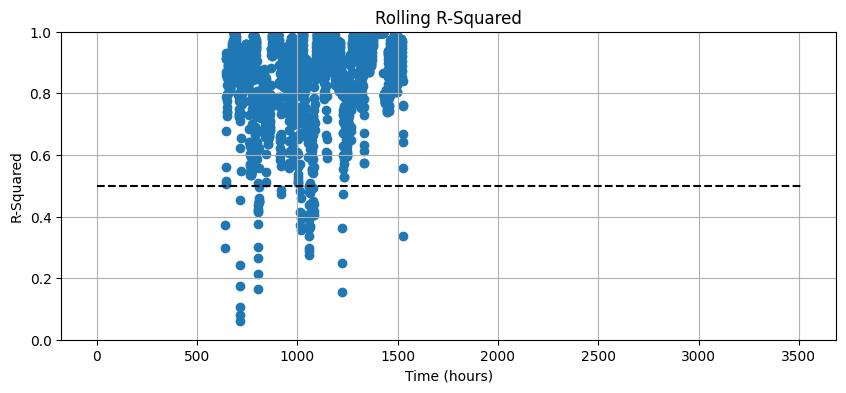

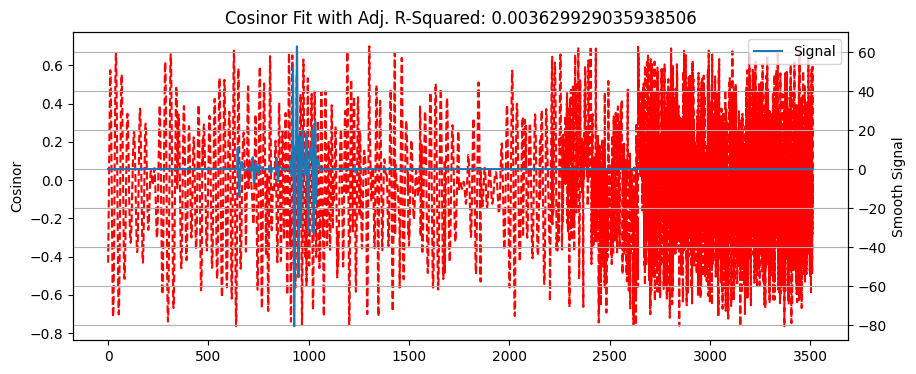

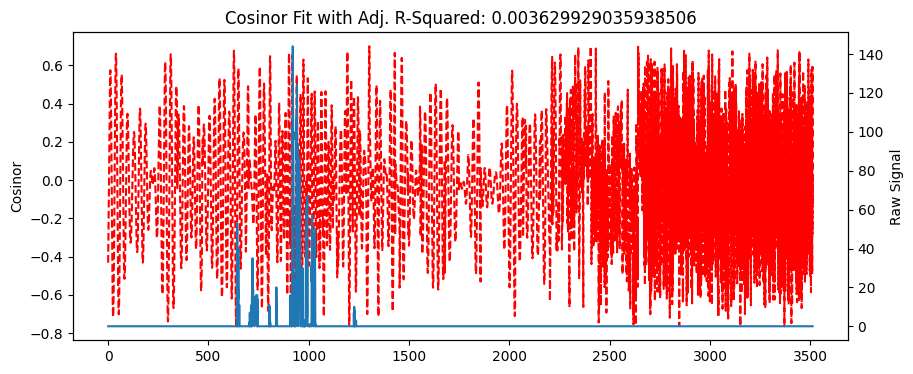

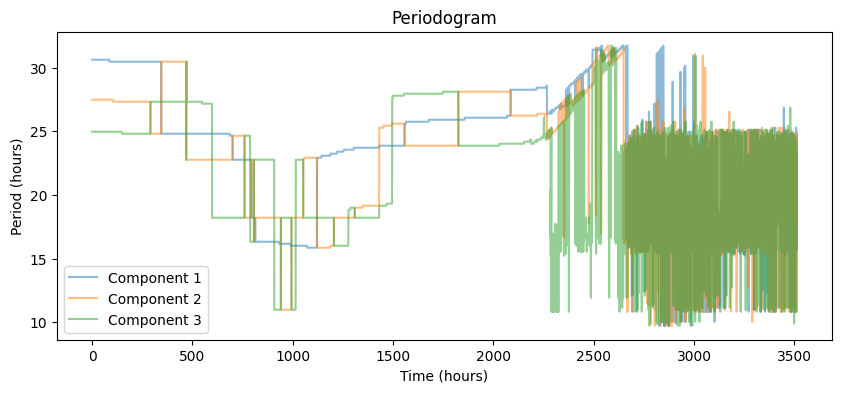

In [84]:
print(f"List of individual variables: {np.arange(activity.shape[1])}")
# Select the activity of an IND of interest
ind = 0
samples_per_hour = 2
max_period = 32
min_period = 8
number_of_components = 3
signal = activity[:,ind]

# Plot the actogram
# actogram(signal, sampling_rate = samples_per_hour)
#Smooth the signal for analysis
smooth_signal = signal_smoother(signal, sampling_rate = samples_per_hour, min_period = min_period, max_period = max_period, order = 2)
print('The signal has been smoothed.')
# Extract the frequency components of the signal
freqs = cwt_compute(smooth_signal, sampling_rate = samples_per_hour, min_period = min_period, max_period = max_period, components = number_of_components)
print('The frequency components have been extracted.')
#Generate a synthetic signal with the same frequency components
synthetic_signal = multicomponent_cosinor(freqs)
print('The synthetic signal has been generated.')
#Fit a cosinor model to the signal
cosinor_model = cosinor_lm(smooth_signal, synthetic_signal)
print('The cosinor model has been fit.')
#Fit a rolling cosinor model to the signal
rolling_cosinor_model = rolling_cosinor_lm(smooth_signal, synthetic_signal, sampling_rate = samples_per_hour, max_period = max_period)
print('The rolling cosinor model has been fit.')
#Adjust the synthetic signal to the cosinor model
synthetic_signal = adjust_synthetic_signal(synthetic_signal, cosinor_model)
print('The synthetic signal has been adjusted.')
#Plot the results
convenience_reporter(signal, smooth_signal, synthetic_signal, freqs, cosinor_model, rolling_cosinor_model, sampling_rate = samples_per_hour,  path = None)

In [117]:
# report the results
def convenience_reporter(signal, smooth_signal, synthetic_signal, freqs, cosinor_model, rolling_cosinor_model, sampling_rate = 60,  path = None):
        
        times = np.arange(0, len(signal)) / sampling_rate

        fig, ax = plt.subplots(5, 1)
        fig.set_size_inches(10, 20)

        # Raw Signal
        ax[0].plot(times, signal)
        ax[0].set_ylabel('Raw Signal')
        ax[0].grid(True)




        # Rolling R-Squared
        ax[1].scatter(times, rolling_cosinor_model)
        ax[1].hlines(0.5, xmin=0, xmax=times[-1], linestyles='--', color='black')
        ax[1].set_ylim(0,1)
        ax[1].set_title('Rolling R-Squared')
        ax[1].set_ylabel('R-Squared')
        ax[1].grid(True)


        # Cosinor Fit with Smoothed Data
    
        # Set figure size
        ax[2].plot(times, synthetic_signal.sum(axis=0), label='Cosinor', linestyle='--', color='red')
        # Create the second plot
        axtwin = ax[2].twinx()
        axtwin.plot(times, smooth_signal, label='Signal')
        # Set the labels for the two y axes
        ax[2].set_ylabel('Cosinor')
        axtwin.set_ylabel('Smooth Signal')

        ax[2].set_title(f'Cosinor Fit with Adj. R-Squared: {cosinor_model.rsquared_adj}')
        ax[2].grid(True)
        ax[2].legend()


        # Cosinor Fit with Raw Data
  
        # Set figure size
        ax[3].plot(times, synthetic_signal.sum(axis=0), label='Cosinor', linestyle='--', color='red')
        # Create the second plot
        axtwin = ax[3].twinx()
        axtwin.plot(times, signal, label='Signal')
        # Set the labels for the two y axes
        ax[3].set_ylabel('Cosinor')
        axtwin.set_ylabel('Raw Signal')
        ax[3].set_title(f'Cosinor Fit with Adj. R-Squared: {cosinor_model.rsquared_adj}')
        ax[3].grid(True)
        ax[3].legend()

        # Periodogram
        for i in range(freqs.shape[0]):
            ax[4].plot(times, (1/freqs[i, :])/sampling_rate, label= f'Component {i+1}', alpha = 0.5)
            ax[4].set_xlabel('Time (hours)')
            ax[4].set_ylabel('Period (hours)')
            ax[4].set_title('Periodogram')
            ax[4].legend()
        


        return fig, ax

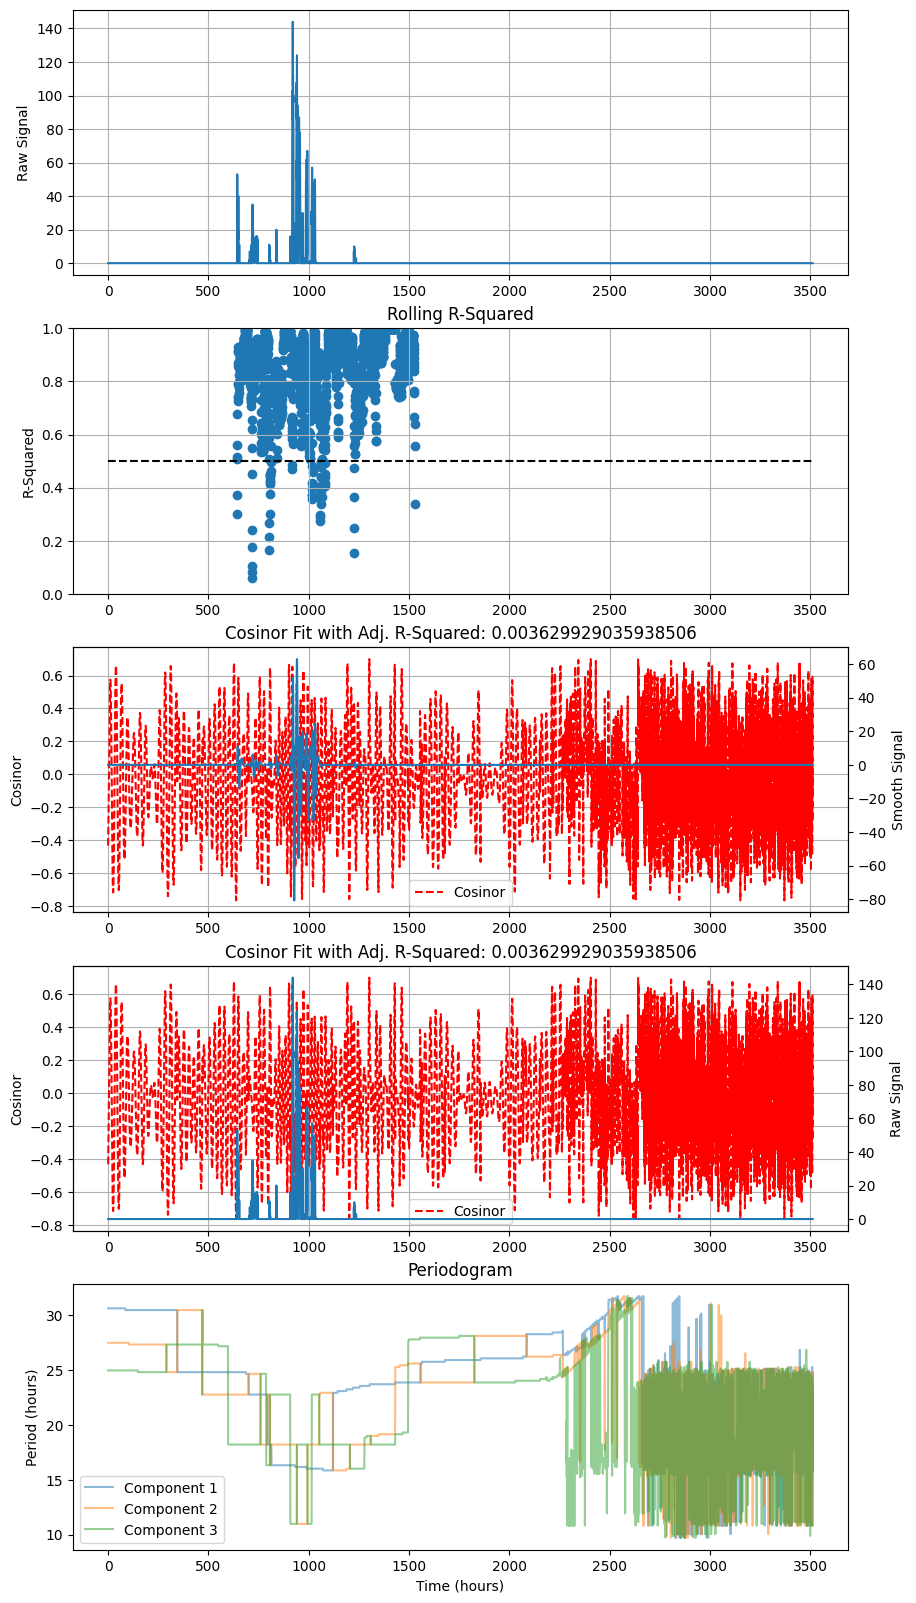

In [119]:
fig, ax = convenience_reporter(signal, smooth_signal, synthetic_signal, freqs, cosinor_model, rolling_cosinor_model, sampling_rate = samples_per_hour,  path = None)